# Using ktrain for performing text classification


Using Hugging Face NLP to perform text classification
We used ktrain for simplicity and to illusrate the end to end flow of training a model using DistilBert
Sicne v0.8x, ktran provides a wrapper on the Hugging Face transformers library


In [1]:
%reload_ext autoreload
%autoreload 2

## Data Preparation

In [2]:
import pandas as pd

# Read the Amazon Github Hun repo files and show the first few rows
amazonreviews_df = pd.read_json('./data/amazon_github_repos.json',lines=True)
amazonreviews_df.head()


,id,node_id,name,full_name,private,owner,html_url,description,fork,url,...,open_issues_count,license,forks,open_issues,watchers,default_branch,permissions,score,readme,label
0,61861755,MDEwOlJlcG9zaXRvcnk2MTg2MTc1NQ==,alexa-skills-kit-sdk-for-nodejs,alexa/alexa-skills-kit-sdk-for-nodejs,False,"{'login': 'alexa', 'id': 17815977, 'node_id': ...",https://github.com/alexa/alexa-skills-kit-sdk-...,The Alexa Skills Kit SDK for Node.js helps you...,False,https://api.github.com/repos/alexa/alexa-skill...,...,8,"{'key': 'apache-2.0', 'name': 'Apache License ...",670,8,2811,2.0.x,"{'admin': False, 'push': False, 'pull': True}",1,"<p align=""center"">\n <img src=""https://m.medi...",API
1,84138837,MDEwOlJlcG9zaXRvcnk4NDEzODgzNw==,alexa-cookbook,alexa/alexa-cookbook,False,"{'login': 'alexa', 'id': 17815977, 'node_id': ...",https://github.com/alexa/alexa-cookbook,A series of sample code projects to be used fo...,False,https://api.github.com/repos/alexa/alexa-cookbook,...,13,"{'key': 'other', 'name': 'Other', 'spdx_id': '...",912,13,1557,master,"{'admin': False, 'push': False, 'pull': True}",1,\n# Alexa Skill Building Cookbook\n\n<div styl...,API
2,63275452,MDEwOlJlcG9zaXRvcnk2MzI3NTQ1Mg==,skill-sample-nodejs-fact,alexa/skill-sample-nodejs-fact,False,"{'login': 'alexa', 'id': 17815977, 'node_id': ...",https://github.com/alexa/skill-sample-nodejs-fact,Build An Alexa Fact Skill,False,https://api.github.com/repos/alexa/skill-sampl...,...,7,"{'key': 'apache-2.0', 'name': 'Apache License ...",1186,7,1002,master,"{'admin': False, 'push': False, 'pull': True}",1,"# Build An Alexa Fact Skill\n<img src=""https:/...",API
3,81483877,MDEwOlJlcG9zaXRvcnk4MTQ4Mzg3Nw==,avs-device-sdk,alexa/avs-device-sdk,False,"{'login': 'alexa', 'id': 17815977, 'node_id': ...",https://github.com/alexa/avs-device-sdk,An SDK for commercial device makers to integra...,False,https://api.github.com/repos/alexa/avs-device-sdk,...,54,"{'key': 'apache-2.0', 'name': 'Apache License ...",477,54,993,master,"{'admin': False, 'push': False, 'pull': True}",1,### What is the Alexa Voice Service (AVS)?\n\n...,API
4,38904647,MDEwOlJlcG9zaXRvcnkzODkwNDY0Nw==,alexa-skills-kit-sdk-for-java,alexa/alexa-skills-kit-sdk-for-java,False,"{'login': 'alexa', 'id': 17815977, 'node_id': ...",https://github.com/alexa/alexa-skills-kit-sdk-...,The Alexa Skills Kit SDK for Java helps you ge...,False,https://api.github.com/repos/alexa/alexa-skill...,...,2,"{'key': 'apache-2.0', 'name': 'Apache License ...",720,2,715,2.0.x,"{'admin': False, 'push': False, 'pull': True}",1,"<p align=""center"">\n <img src=""https://m.medi...",API


In [3]:
# Get the unique labels 
categories = amazonreviews_df.label.unique()
categories

array(['API', 'RESEARCH', 'GENERAL', 'OTHER', 'DEAD'], dtype=object)

In [4]:
# count each of the labels
amazonreviews_df['label'].value_counts()

API         2265
GENERAL      279
DEAD          14
RESEARCH       9
OTHER          1
Name: label, dtype: int64

In [5]:
# Focus on API and GENERAL labels only
amazonreviews_df = amazonreviews_df[amazonreviews_df['label'].isin(['API', 'GENERAL'])]
amazonreviews_df['label'].value_counts()

API        2265
GENERAL     279
Name: label, dtype: int64

In [6]:
# remove rows that contain NA
# Focus on API and GENERAL labels only
amazonreviews_df = amazonreviews_df[amazonreviews_df['readme'].notna()]
amazonreviews_df = amazonreviews_df[amazonreviews_df['label'].isin(['API', 'GENERAL'])]

# count the number of rows after removing rows that contain NA, and only rows that has a label API, General
amazonreviews_df['label'].value_counts()

API        2186
GENERAL     259
Name: label, dtype: int64

In [7]:
# Convert labels to integers
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
amazonreviews_df['labelcode'] = LE.fit_transform(amazonreviews_df['label'])
amazonreviews_df['labelcode'].value_counts()

0    2186
1     259
Name: labelcode, dtype: int64

## Preparing the training and test data

In [8]:
# Prepare training and test data
from sklearn.model_selection import train_test_split

# Drop the columns - label and fork 
# X = amazonreviews_df.drop(['label','fork'], axis=1)
X = amazonreviews_df['readme']

# What's in the Readme for the review
print(X.head())

0    <p align="center">\n  <img src="https://m.medi...
1    \n# Alexa Skill Building Cookbook\n\n<div styl...
2    # Build An Alexa Fact Skill\n<img src="https:/...
3    ### What is the Alexa Voice Service (AVS)?\n\n...
4    <p align="center">\n  <img src="https://m.medi...
Name: readme, dtype: object


In [9]:
# get the labels
labels = amazonreviews_df.labelcode

# Split the data into train/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.30, random_state=98052)


In [10]:
# Count of label 0 and 1 in the training data set
print("Rows in X_train %d : " % len(X_train))
type(X_train.values.tolist())

y_train.value_counts()


Rows in X_train 1711 : 


0    1526
1     185
Name: labelcode, dtype: int64

In [11]:
# Count of label 0 and 1 in the test data set
y_test.value_counts()


0    660
1     74
Name: labelcode, dtype: int64

In [33]:
# Getting the dataset ready for using RandomUnderSampler
import numpy as np

X_train_np = X_train.to_numpy()
X_test_np =  X_test.to_numpy()

# Convert 1D to 2D (used as input to sampler)
X_train_np2D = np.reshape(X_train_np,(-1,1))
X_test_np2D = np.reshape(X_test_np,(-1,1))

In [42]:
#Reference materials.
#https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html
#https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/applications/plot_topic_classication.html#sphx-glr-auto-examples-applications-plot-topic-classication-py
#https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
from imblearn.under_sampling import RandomUnderSampler

# Perform random under-sampling
sampler = RandomUnderSampler(random_state = 98053)
X_train_rus, Y_train_rus = sampler.fit_resample(X_train_np2D, y_train)
X_test_rus, Y_test_rus = sampler.fit_resample(X_test_np2D, y_test)



In [43]:
from collections import Counter

print('Resampled Training dataset  %s' % Counter(Y_train_rus))
print('Resampled Test dataset %s' % Counter(Y_test_rus))

Resampled Training dataset  Counter({0: 185, 1: 185})
Resampled Test dataset Counter({0: 74, 1: 74})


In [44]:
# Preparing the resampled datasets
# flatten train and test dataset 
X_train_rus = X_train_rus.flatten()
X_test_rus = X_test_rus.flatten()


In [45]:
import ktrain
from ktrain import text

model_name = 'distilbert-base-uncased'
t = text.Transformer(model_name, class_names=labels.unique(), maxlen=500)


In [46]:
#train = t.preprocess_train(X_train.values, y_train.values)
train = t.preprocess_train(X_train_rus.tolist(), Y_train_rus.to_list())



preprocessing train...
language: en
train sequence lengths:
	mean : 519
	95percentile : 1998
	99percentile : 3098


In [47]:
val = t.preprocess_test(X_test_rus.tolist(), Y_test_rus.to_list())


preprocessing test...
language: en
test sequence lengths:
	mean : 665
	95percentile : 2450
	99percentile : 5125


In [49]:
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=8)
                            

simulating training for different learning rates... this may take a few moments...
Train for 46 steps
Epoch 1/5
46/46 [==============================] - 50s 1s/step - loss: 0.6926 - accuracy: 0.5082
Epoch 2/5
46/46 [==============================] - 42s 923ms/step - loss: 0.6559 - accuracy: 0.5856
Epoch 3/5
46/46 [==============================] - 42s 923ms/step - loss: 0.6955 - accuracy: 0.5635
Epoch 4/5
34/46 [=====================>........] - ETA: 11s - loss: 4.6879 - accuracy: 0.5226

done.
Visually inspect loss plot and select learning rate associated with falling loss


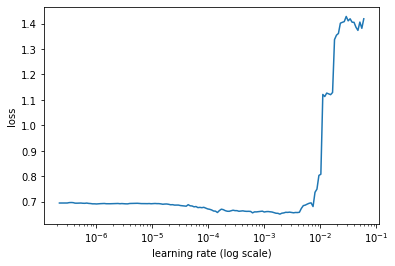

In [51]:
# Find a good learning rate 
# The results from lr_find are visualized, where the x-axis is the learning rate (log scale) and y-axis is the loss
# Using lr_find, you will see the loss stopps decreasing, and starts to increase
# In general, will be good to pick a learning rate near the lowest point of the graph
learner.lr_find(show_plot=True, max_epochs=5)

In [52]:
learner.fit_onecycle(8e-5, 5)



begin training using onecycle policy with max lr of 8e-05...
Train for 47 steps, validate for 5 steps
Epoch 1/5
47/47 [==============================] - 57s 1s/step - loss: 0.6766 - accuracy: 0.5730 - val_loss: 0.6206 - val_accuracy: 0.5608
Epoch 2/5
47/47 [==============================] - 49s 1s/step - loss: 0.5527 - accuracy: 0.7378 - val_loss: 0.5280 - val_accuracy: 0.7432
Epoch 3/5
47/47 [==============================] - 49s 1s/step - loss: 0.4856 - accuracy: 0.7892 - val_loss: 0.5152 - val_accuracy: 0.6892
Epoch 4/5
47/47 [==============================] - 49s 1s/step - loss: 0.3393 - accuracy: 0.8730 - val_loss: 0.6823 - val_accuracy: 0.7162
Epoch 5/5
47/47 [==============================] - 49s 1s/step - loss: 0.2513 - accuracy: 0.8919 - val_loss: 0.6533 - val_accuracy: 0.7027


In [53]:
t.get_classes()

[0, 1]

In [54]:
learner.validate(class_names=t.get_classes())

precision    recall  f1-score   support

           0       0.69      0.74      0.71        74
           1       0.72      0.66      0.69        74

    accuracy                           0.70       148
   macro avg       0.70      0.70      0.70       148
weighted avg       0.70      0.70      0.70       148



array([[55, 19],
       [25, 49]])

In [55]:
# show the top 3 rows where the model made mistakes
learner.view_top_losses(n=3, preproc=t)

----------
id:3 | loss:3.29 | true:0 | pred:1)

----------
id:91 | loss:3.25 | true:1 | pred:0)

----------
id:0 | loss:3.24 | true:0 | pred:1)



In [61]:
# Show the readme for the entry where we made mistakes
# We predicted GENERAL, when this should be predicted as API
# Note: This is based on the quality of the hand-labeling and weak labels
# This example is used for demonstration purpose only.
print("Ground truth: %d" % Y_test_rus[3])
print("-------------")

# this was predicted as a GENERAL category
# Ground truth indicates that this is API
print(X_test_rus[3])


Ground truth: 0
-------------
[![Maven Central](https://maven-badges.herokuapp.com/maven-central/com.amazon.pay/amazon-pay-java-sdk/badge.svg)](https://maven-badges.herokuapp.com/maven-central/com.amazon.pay/amazon-pay-java-sdk)

### Amazon Pay Java SDK

### Requirements

* Amazon Pay - [Register here](https://pay.amazon.com/signup)
* Java 1.6 or higher *(including JCE Java Cryptography Extension)*
* Apache Commons Logging 1.2 *(or JCL-over-SLF4J drop in replacement)*
* Apache Commons Codec 1.10
* Google Gson 2.2.2 or higher *(for GetUserInfo and IPN handling only)*

Amazon Pay API Integration

```java
import com.amazon.pay.Client;
import com.amazon.pay.Config;
import com.amazon.pay.impl.PayClient;
import com.amazon.pay.impl.PayConfig;
```

 Your Amazon Pay keys are
 available in your Seller Central account

```java
String merchantId = "YOUR_MERCHANT_ID";
String accessKey = "YOUR_ACCESS_KEY";
String secretKey = "YOUR_SECRET_Key";

Config config = new PayConfig()
                .withSe

## Let's use this model for prediction for a new readme

In [57]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [58]:
amazongithub_readme = 'The Alexa APIs for Python consists of python classes that represent the request and response JSON of Alexa services. These models act as a core dependency for the Alexa Skills Kit Python SDK.'

In [59]:
# using the README from https://github.com/alexa/alexa-apis-for-python
predictor.predict(amazongithub_readme)

In [60]:
predictor.explain(amazongithub_readme)